## Notebook 02: Deep Feature Analysis
Objective: Deep dive into vitals, labs, comorbidities, correlations, statistical tests

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr
import json
import warnings
warnings.filterwarnings('ignore')

# Visualization configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("="*80)
print("DAY 2: DEEP FEATURE ANALYSIS")
print("="*80)
print("✅ All libraries loaded successfully\n")

DAY 2: DEEP FEATURE ANALYSIS
✅ All libraries loaded successfully



In [9]:
print("\n" + "="*80)
print("LOADING DATA & DAY 1 RESULTS")
print("="*80)

# Load training data
print("\n⏳ Loading training_v2.csv...")
df = pd.read_csv(r'C:\1Personal drive\job prep\me\D Analyst prep\Projects\ICU-Mortality-Prediction-WiDS2020\data\raw\training_v2.csv')
print(f"✅ Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Recreate age groups (from Day 1)
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 60, 75, 120], 
                          labels=['<40', '40-60', '60-75', '>75'])

# Load feature categories from Day 1
try:
    with open(r'C:\1Personal drive\job prep\me\D Analyst prep\Projects\ICU-Mortality-Prediction-WiDS2020\Outputs\reports\feature_categories.json', 'r') as f:
        feature_categories = json.load(f)
    print("✅ Feature categories loaded from Day 1")
except FileNotFoundError:
    print("⚠️  feature_categories.json not found - creating basic categories")
    feature_categories = {
        'Demographics': ['age', 'bmi', 'gender', 'ethnicity', 'weight', 'height'],
        'APACHE Scores': [col for col in df.columns if 'apache' in col.lower()],
        'Vital Signs': [col for col in df.columns if any(x in col for x in ['heart_rate', 'temp', 'bp', 'resprate', 'spo2'])],
        'Lab Results': [col for col in df.columns if any(x in col for x in ['glucose', 'creatinine', 'sodium', 'lactate', 'wbc'])],
        'Comorbidities': [col for col in df.columns if any(x in col for x in ['aids', 'cirrhosis', 'diabetes', 'hepatic', 'tumor'])]
    }
# 2. FEATURE ENGINEERING: Calculate Means (CRITICAL FIX)
# The dataset has min/max but not mean. We must calculate it.
print("\n🛠️ Generating 'Mean' columns for Vitals and Labs...")

vital_roots = ['d1_heartrate', 'd1_mbp', 'd1_resprate', 'd1_temp', 'd1_spo2', 
               'd1_glucose', 'd1_creatinine', 'd1_sodium', 'd1_potassium', 
               'd1_wbc', 'd1_hemoglobin', 'd1_platelets', 'd1_lactate']

count = 0
for root in vital_roots:
    min_col = f"{root}_min"
    max_col = f"{root}_max"
    mean_col = f"{root}_mean"
    
    # Check if min/max exist, then create mean
    if min_col in df.columns and max_col in df.columns:
        # Avoid filling NaN if both aren't present, just average them
        df[mean_col] = (df[min_col] + df[max_col]) / 2
        count += 1

print(f"✅ Created {count} new '_mean' columns.")

# 3. Create Age Groups
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 60, 75, 120], 
                         labels=['<40', '40-60', '60-75', '>75'])




LOADING DATA & DAY 1 RESULTS

⏳ Loading training_v2.csv...
✅ Data loaded: 91,713 rows × 186 columns
✅ Feature categories loaded from Day 1

🛠️ Generating 'Mean' columns for Vitals and Labs...
✅ Created 12 new '_mean' columns.


In [3]:
print("\n🎯 Today's Focus:")
print("   1. Vital Signs (Heart Rate, BP, Respiratory Rate, Temperature, SpO2)")
print("   2. Lab Results (Blood chemistry, hematology)")
print("   3. Comorbidities (Chronic conditions impact)")
print("   4. ICU Characteristics (Type, admission source, ventilation)")
print("   5. Feature Correlations (Which features matter most?)")
print("   6. Statistical Hypothesis Testing (Formal validation)")


🎯 Today's Focus:
   1. Vital Signs (Heart Rate, BP, Respiratory Rate, Temperature, SpO2)
   2. Lab Results (Blood chemistry, hematology)
   3. Comorbidities (Chronic conditions impact)
   4. ICU Characteristics (Type, admission source, ventilation)
   5. Feature Correlations (Which features matter most?)
   6. Statistical Hypothesis Testing (Formal validation)



💓 VITAL SIGNS: SURVIVORS VS NON-SURVIVORS

           Vital  Survived_Mean  Died_Mean  Difference  P_Value Significant
      Heart Rate          86.12      92.40        6.28     0.00           ✅
         Mean BP          85.29      79.21       -6.08     0.00           ✅
Respiratory Rate          20.68      22.87        2.20     0.00           ✅
     Temperature          36.80      36.53       -0.27     0.00           ✅
            SpO2          95.17      91.39       -3.78     0.00           ✅


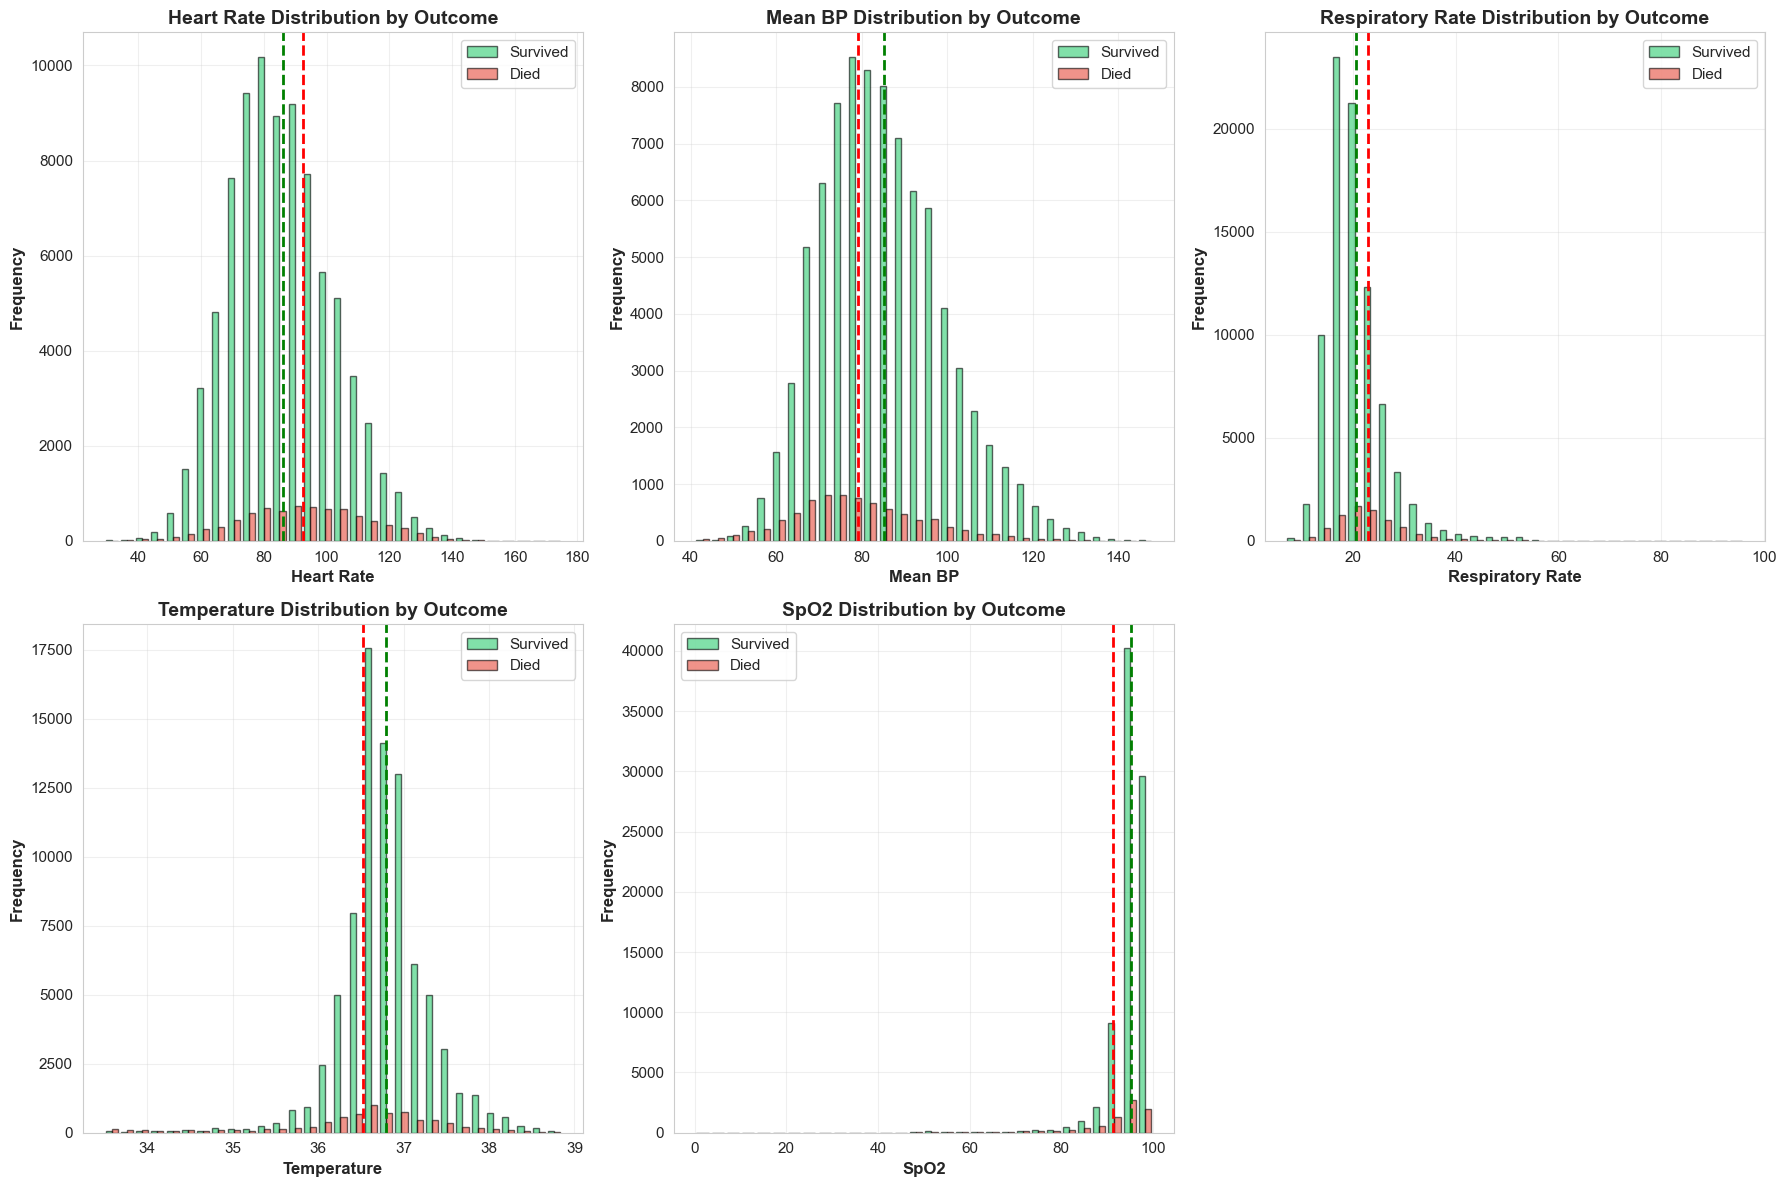


✅ Visualization saved: outputs/figures/06_vital_signs_analysis.png
✅ Report saved: outputs/reports/vital_signs_comparison.csv


In [10]:

# Identify vital sign features
vital_patterns = ['heart_rate', 'd1_heartrate', 'h1_heartrate',
                   'd1_mbp', 'h1_mbp', 'd1_sysbp', 'h1_sysbp',
                   'd1_resprate', 'h1_resprate',
                   'd1_temp', 'h1_temp',
                   'd1_spo2', 'h1_spo2']

vital_features = [col for col in df.columns if any(v in col for v in vital_patterns)]



# Focus on key vitals (mean values over first 24 hours)
key_vitals = {
    'Heart Rate': 'd1_heartrate_mean',
    'Mean BP': 'd1_mbp_mean',
    'Respiratory Rate': 'd1_resprate_mean',
    'Temperature': 'd1_temp_mean',
    'SpO2': 'd1_spo2_mean'
}

# Statistics by outcome
print(f"\n💓 VITAL SIGNS: SURVIVORS VS NON-SURVIVORS\n")

vital_comparison = pd.DataFrame()

for vital_name, vital_col in key_vitals.items():
    if vital_col in df.columns:
        survived_mean = df[df['hospital_death'] == 0][vital_col].mean()
        died_mean = df[df['hospital_death'] == 1][vital_col].mean()
        difference = died_mean - survived_mean
        
        # T-test
        survived_vals = df[df['hospital_death'] == 0][vital_col].dropna()
        died_vals = df[df['hospital_death'] == 1][vital_col].dropna()
        
        if len(survived_vals) > 0 and len(died_vals) > 0:
            t_stat, p_val = stats.ttest_ind(survived_vals, died_vals)
            
            vital_comparison = pd.concat([vital_comparison, pd.DataFrame({
                'Vital': [vital_name],
                'Survived_Mean': [survived_mean],
                'Died_Mean': [died_mean],
                'Difference': [difference],
                'P_Value': [p_val],
                'Significant': ['✅' if p_val < 0.001 else '❌']
            })], ignore_index=True)

print(vital_comparison.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

plot_idx = 0
for vital_name, vital_col in key_vitals.items():
    if vital_col in df.columns and plot_idx < 6:
        survived_vals = df[df['hospital_death'] == 0][vital_col].dropna()
        died_vals = df[df['hospital_death'] == 1][vital_col].dropna()
        
        axes[plot_idx].hist([survived_vals, died_vals], bins=30, 
                             label=['Survived', 'Died'],
                             color=['#2ecc71', '#e74c3c'], alpha=0.6, edgecolor='black')
        axes[plot_idx].axvline(survived_vals.mean(), color='green', linestyle='--', linewidth=2)
        axes[plot_idx].axvline(died_vals.mean(), color='red', linestyle='--', linewidth=2)
        axes[plot_idx].set_xlabel(vital_name, fontweight='bold')
        axes[plot_idx].set_ylabel('Frequency', fontweight='bold')
        axes[plot_idx].set_title(f'{vital_name} Distribution by Outcome', fontweight='bold')
        axes[plot_idx].legend()
        axes[plot_idx].grid(alpha=0.3)
        
        plot_idx += 1

if plot_idx < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.savefig(r'C:\1Personal drive\job prep\me\D Analyst prep\Projects\ICU-Mortality-Prediction-WiDS2020\Outputs\Figures\06_vital_signs_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: outputs/figures/06_vital_signs_analysis.png")

# Save comparison
vital_comparison.to_csv(r'C:\1Personal drive\job prep\me\D Analyst prep\Projects\ICU-Mortality-Prediction-WiDS2020\Outputs\reports\vital_signs_comparison.csv', index=False)
print("✅ Report saved: outputs/reports/vital_signs_comparison.csv")



🧪 KEY LAB RESULTS: SURVIVORS VS NON-SURVIVORS
  Lab Test  Survived_Mean  Died_Mean  Pct_Diff  P_Value
   Glucose         143.24     157.84     10.19     0.00
Creatinine           1.38       1.94     40.75     0.00
    Sodium         138.39     138.80      0.30     0.00
 Potassium           4.08       4.24      3.90     0.00
       WBC          11.63      14.65     25.93     0.00
 Platelets         203.14     189.33     -6.80     0.00
   Lactate           2.05       4.80    134.16     0.00


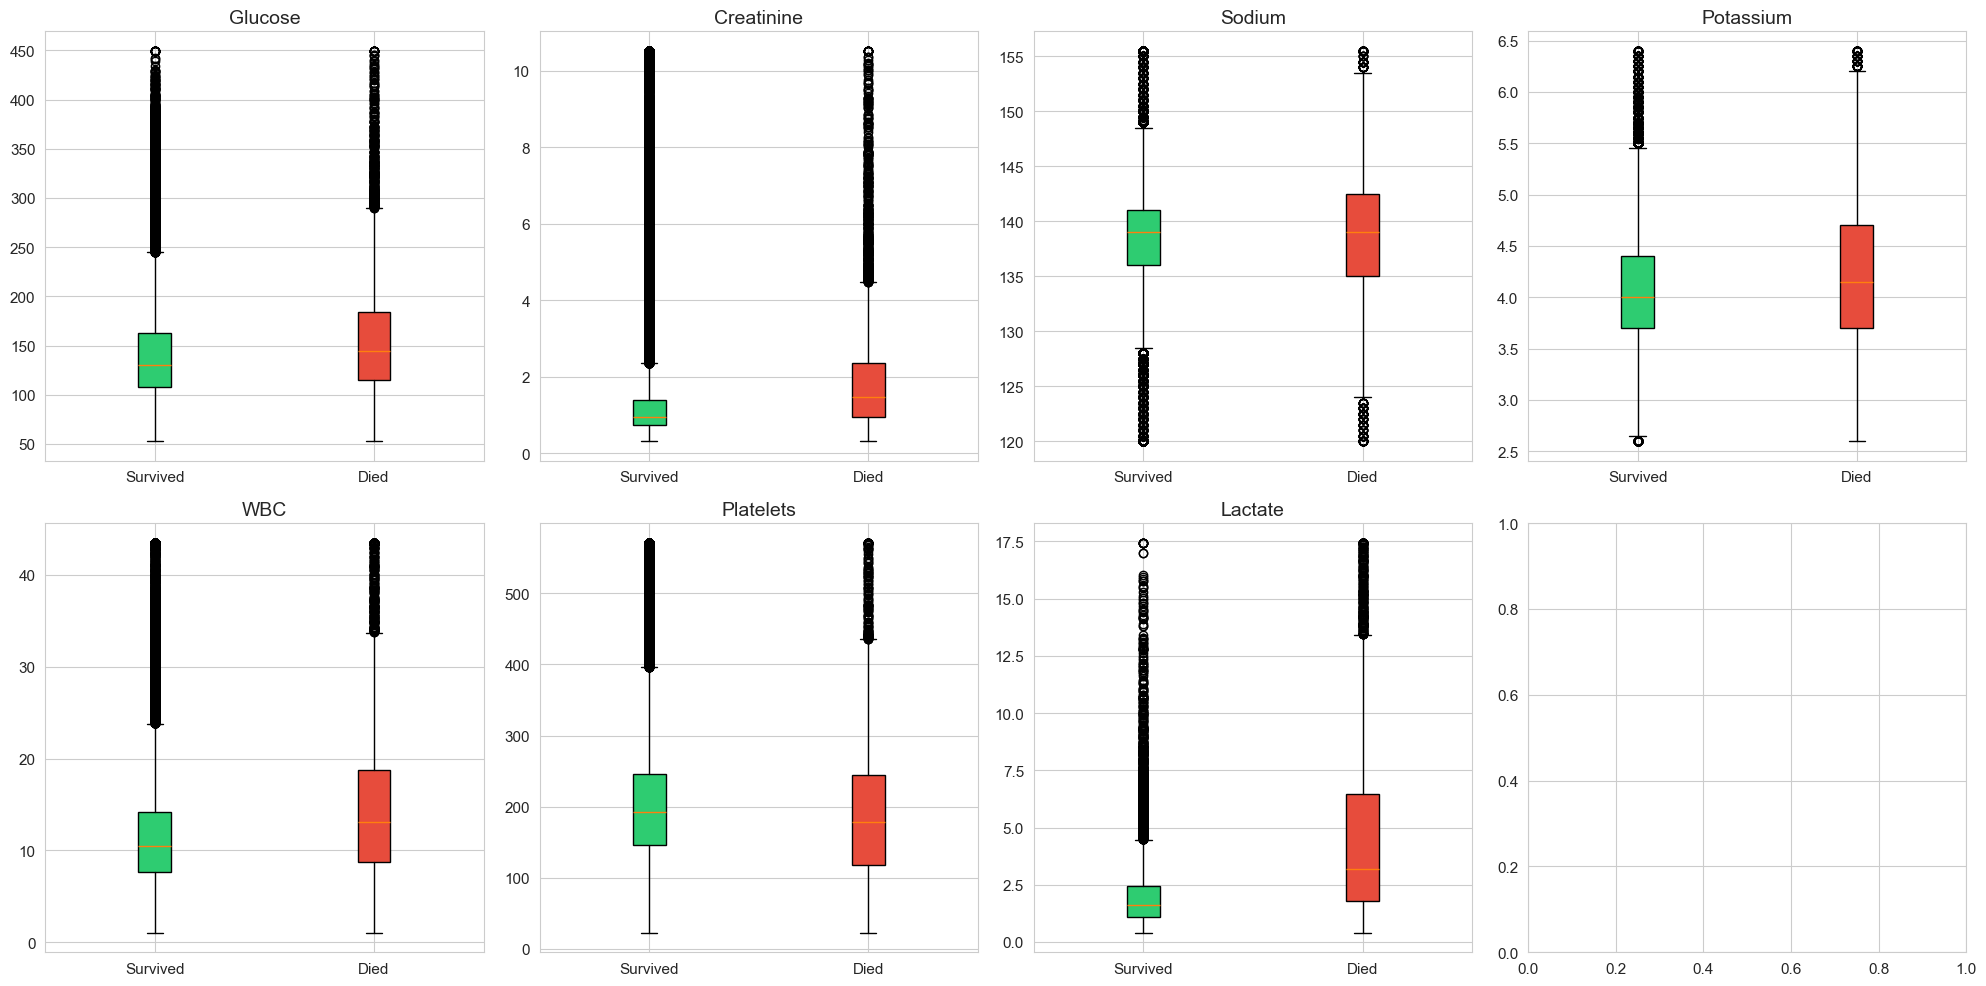

In [17]:
# ============================================================================
# SECTION 3: LAB RESULTS ANALYSIS
# ============================================================================

key_labs = {
    'Glucose': 'd1_glucose_mean',
    'Creatinine': 'd1_creatinine_mean',
    'Sodium': 'd1_sodium_mean',
    'Potassium': 'd1_potassium_mean',
    'WBC': 'd1_wbc_mean',
    'Hemoglobin': 'd1_hemoglobin_mean',
    'Platelets': 'd1_platelets_mean',
    'Lactate': 'd1_lactate_mean'
}

print(f"\n🧪 KEY LAB RESULTS: SURVIVORS VS NON-SURVIVORS")
lab_comparison = pd.DataFrame()

for lab_name, lab_col in key_labs.items():
    if lab_col in df.columns:
        survived_vals = df[df['hospital_death'] == 0][lab_col].dropna()
        died_vals = df[df['hospital_death'] == 1][lab_col].dropna()
        
        if len(survived_vals) > 0 and len(died_vals) > 0:
            t_stat, p_val = stats.ttest_ind(survived_vals, died_vals)
            lab_comparison = pd.concat([lab_comparison, pd.DataFrame({
                'Lab Test': [lab_name],
                'Survived_Mean': [survived_vals.mean()],
                'Died_Mean': [died_vals.mean()],
                'Pct_Diff': [((died_vals.mean() - survived_vals.mean()) / survived_vals.mean()) * 100],
                'P_Value': [p_val]
            })], ignore_index=True)

print(lab_comparison.to_string(index=False))

# Visualization - Box plots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()
plot_idx = 0

for lab_name, lab_col in key_labs.items():
    if lab_col in df.columns:
        data = [df[df['hospital_death'] == 0][lab_col].dropna(), 
                df[df['hospital_death'] == 1][lab_col].dropna()]
        
        bp = axes[plot_idx].boxplot(data, labels=['Survived', 'Died'], patch_artist=True)
        
        # Color the boxes
        colors = ['#2ecc71', '#e74c3c']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            
        axes[plot_idx].set_title(lab_name)
        plot_idx += 1

plt.tight_layout()
plt.savefig(r'C:\1Personal drive\job prep\me\D Analyst prep\Projects\ICU-Mortality-Prediction-WiDS2020\Outputs\Figures\07_lab_results_analysis.png', dpi=300)
plt.show()

        Condition  Prevalence_Count  Mortality_With_%  Relative_Risk
      Solid Tumor              1878             18.48           2.20
         Leukemia               643             18.51           2.17
  Hepatic Failure              1182             18.10           2.14
        Cirrhosis              1428             17.37           2.05
         Lymphoma               376             16.76           1.95
Immunosuppression              2381             16.13           1.92
             AIDS                78             12.82           1.49
         Diabetes             20492              7.78           0.88


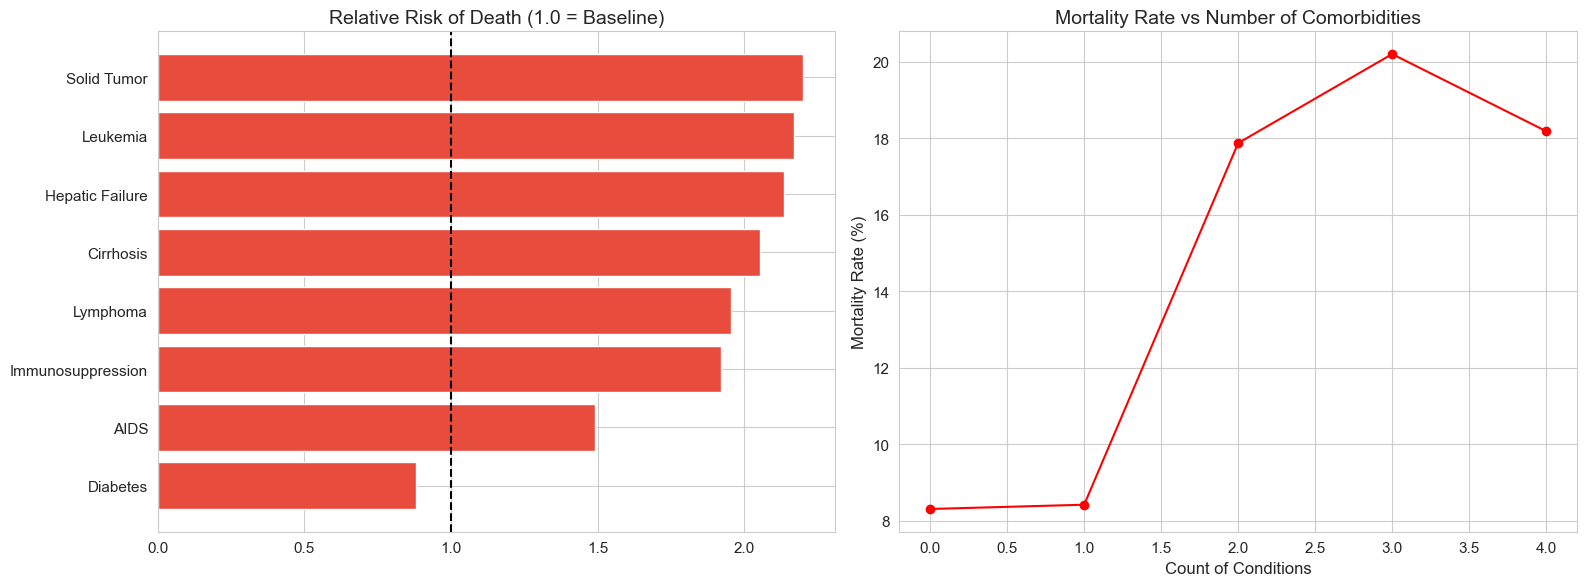

In [18]:
# ============================================================================
# SECTION 4: COMORBIDITIES ANALYSIS
# ============================================================================

comorbidities = {
    'AIDS': 'aids', 'Cirrhosis': 'cirrhosis', 'Diabetes': 'diabetes_mellitus',
    'Hepatic Failure': 'hepatic_failure', 'Immunosuppression': 'immunosuppression',
    'Leukemia': 'leukemia', 'Lymphoma': 'lymphoma', 'Solid Tumor': 'solid_tumor_with_metastasis'
}

comorbidity_analysis = pd.DataFrame()

for condition, col in comorbidities.items():
    if col in df.columns:
        # Calculate stats
        prevalence = (df[col] == 1).sum()
        with_cond = df[df[col] == 1]['hospital_death'].mean() * 100
        without_cond = df[df[col] == 0]['hospital_death'].mean() * 100
        rel_risk = with_cond / without_cond if without_cond > 0 else 0
        
        comorbidity_analysis = pd.concat([comorbidity_analysis, pd.DataFrame({
            'Condition': [condition],
            'Prevalence_Count': [prevalence],
            'Mortality_With_%': [with_cond],
            'Relative_Risk': [rel_risk]
        })], ignore_index=True)

comorbidity_analysis = comorbidity_analysis.sort_values('Relative_Risk', ascending=False)
print(comorbidity_analysis.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Relative risk
axes[0].barh(comorbidity_analysis['Condition'], comorbidity_analysis['Relative_Risk'], color='#e74c3c')
axes[0].axvline(1, color='black', linestyle='--')
axes[0].set_title('Relative Risk of Death (1.0 = Baseline)')
axes[0].invert_yaxis()

# Mortality by Count of Comorbidities
comorb_cols = [v for k,v in comorbidities.items()]
df['comorbidity_count'] = df[comorb_cols].sum(axis=1)
mortality_by_count = df.groupby('comorbidity_count')['hospital_death'].mean() * 100

axes[1].plot(mortality_by_count.index, mortality_by_count.values, marker='o', color='red')
axes[1].set_title('Mortality Rate vs Number of Comorbidities')
axes[1].set_ylabel('Mortality Rate (%)')
axes[1].set_xlabel('Count of Conditions')

plt.tight_layout()
plt.savefig(r'C:\1Personal drive\job prep\me\D Analyst prep\Projects\ICU-Mortality-Prediction-WiDS2020\Outputs\Figures\08_comorbidities_analysis.png', dpi=300)
plt.show()


SECTION 5: ICU ADMISSION CHARACTERISTICS

💀 MORTALITY BY ICU TYPE:

              Count  Deaths  Mortality_Rate_%
icu_type                                     
MICU           7695     930             12.09
Cardiac ICU    4776     494             10.34
Med-Surg ICU  50586    4426              8.75
Neuro ICU      7675     638              8.31
CCU-CTICU      7156     542              7.57
SICU           5209     390              7.49
CTICU          4003     241              6.02
CSICU          4613     254              5.51

💀 MORTALITY BY ADMISSION SOURCE:

                           Count  Deaths  Mortality_Rate_%
icu_admit_source                                          
Other ICU                    859     124             14.44
Other Hospital              2358     317             13.44
Floor                      15611    2094             13.41
Accident & Emergency       54060    4670              8.64
Operating Room / Recovery  18713     698              3.73

💀 MORTALITY BY VENTILA

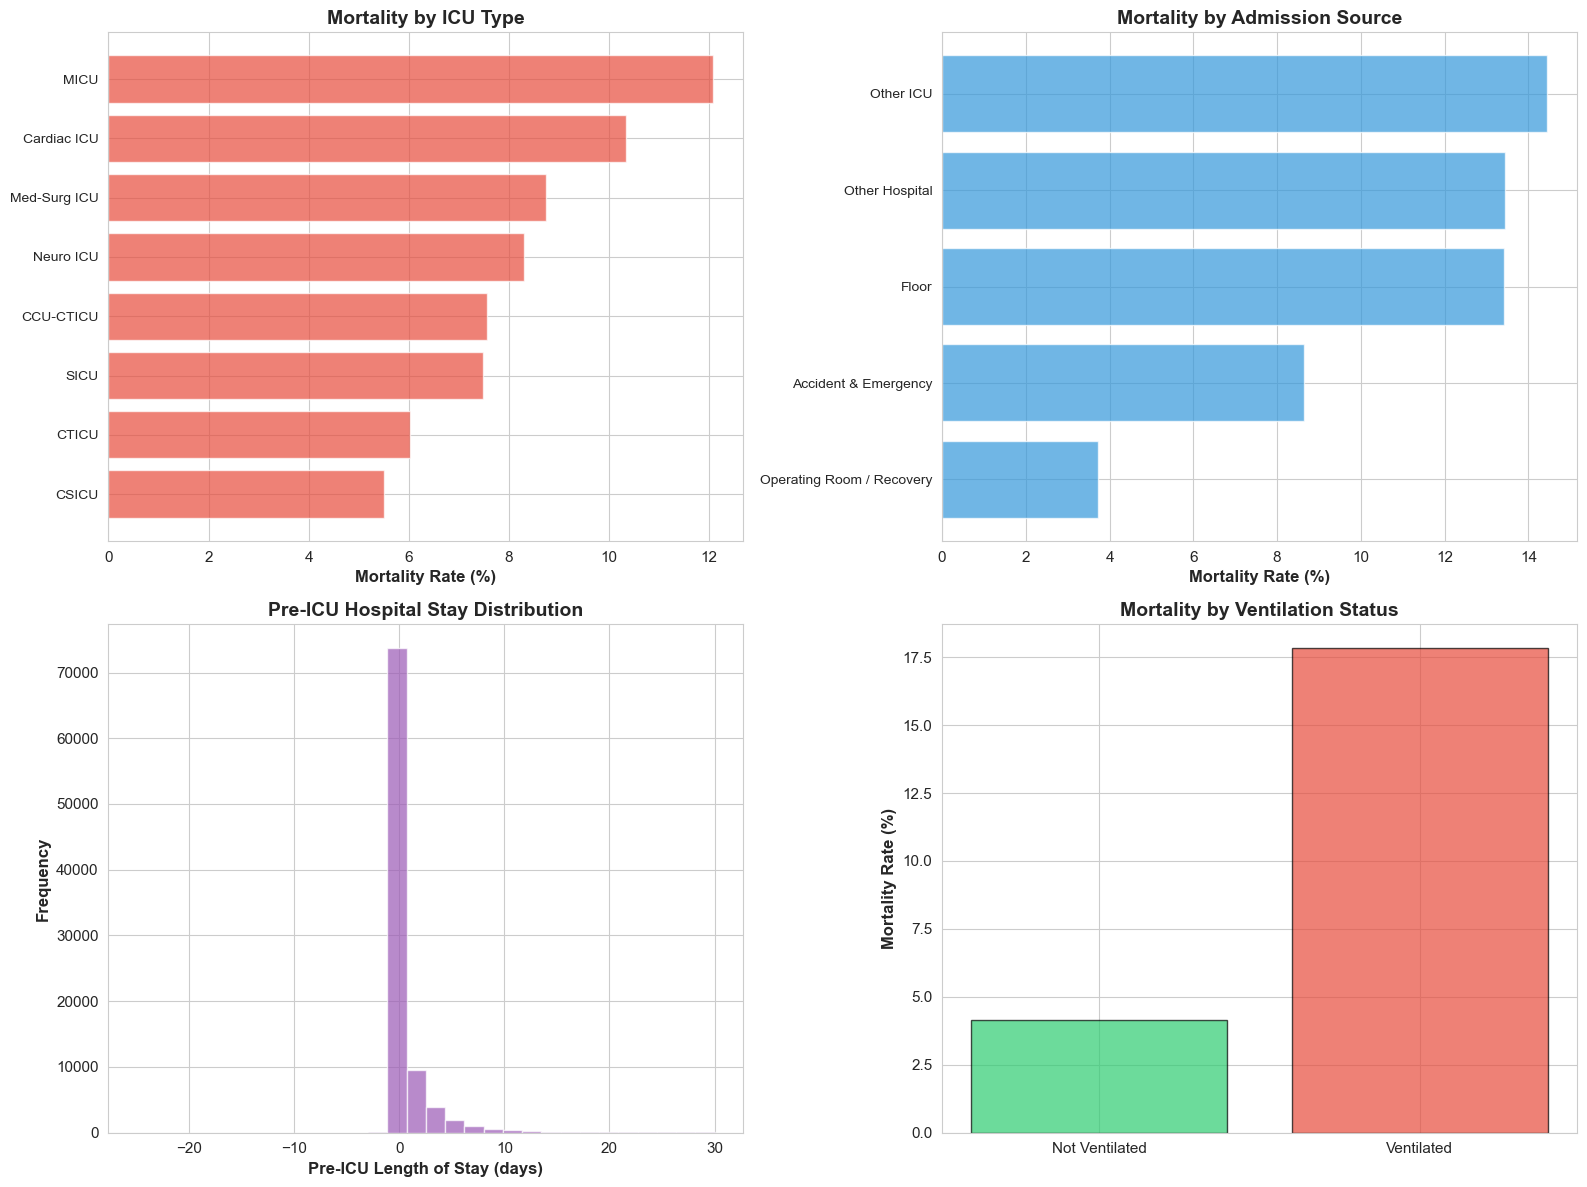


✅ Visualization saved: outputs/figures/09_icu_characteristics.png


In [20]:
print("\n" + "="*80)
print("SECTION 5: ICU ADMISSION CHARACTERISTICS")
print("="*80)

# ICU Type analysis
if 'icu_type' in df.columns:
    mortality_by_icu = df.groupby('icu_type')['hospital_death'].agg([
        ('Count', 'count'),
        ('Deaths', 'sum'),
        ('Mortality_Rate_%', lambda x: x.mean() * 100)
    ]).round(2).sort_values('Mortality_Rate_%', ascending=False)
    
    print(f"\n💀 MORTALITY BY ICU TYPE:\n")
    print(mortality_by_icu.head(10))

# Admission Source
if 'icu_admit_source' in df.columns:
    mortality_by_source = df.groupby('icu_admit_source')['hospital_death'].agg([
        ('Count', 'count'),
        ('Deaths', 'sum'),
        ('Mortality_Rate_%', lambda x: x.mean() * 100)
    ]).round(2).sort_values('Mortality_Rate_%', ascending=False)
    
    print(f"\n💀 MORTALITY BY ADMISSION SOURCE:\n")
    print(mortality_by_source.head(10))

# Ventilation
if 'ventilated_apache' in df.columns:
    vent_mortality = df.groupby('ventilated_apache')['hospital_death'].agg([
        ('Count', 'count'),
        ('Mortality_Rate_%', lambda x: x.mean() * 100)
    ]).round(2)
    print(f"\n💀 MORTALITY BY VENTILATION STATUS:\n")
    print(vent_mortality)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Mortality by ICU type
if 'icu_type' in df.columns:
    top_icu = mortality_by_icu.head(8)
    axes[0, 0].barh(range(len(top_icu)), top_icu['Mortality_Rate_%'], color='#e74c3c', alpha=0.7)
    axes[0, 0].set_yticks(range(len(top_icu)))
    axes[0, 0].set_yticklabels(top_icu.index, fontsize=10)
    axes[0, 0].set_xlabel('Mortality Rate (%)', fontweight='bold')
    axes[0, 0].set_title('Mortality by ICU Type', fontweight='bold')
    axes[0, 0].invert_yaxis()

# Mortality by admission source
if 'icu_admit_source' in df.columns:
    top_source = mortality_by_source.head(8)
    axes[0, 1].barh(range(len(top_source)), top_source['Mortality_Rate_%'], color='#3498db', alpha=0.7)
    axes[0, 1].set_yticks(range(len(top_source)))
    axes[0, 1].set_yticklabels(top_source.index, fontsize=10)
    axes[0, 1].set_xlabel('Mortality Rate (%)', fontweight='bold')
    axes[0, 1].set_title('Mortality by Admission Source', fontweight='bold')
    axes[0, 1].invert_yaxis()

# Pre-ICU LOS
if 'pre_icu_los_days' in df.columns:
    axes[1, 0].hist(df['pre_icu_los_days'].dropna().clip(upper=30), bins=30, color='#9b59b6', alpha=0.7)
    axes[1, 0].set_xlabel('Pre-ICU Length of Stay (days)', fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontweight='bold')
    axes[1, 0].set_title('Pre-ICU Hospital Stay Distribution', fontweight='bold')

# Ventilation status
if 'ventilated_apache' in df.columns:
    axes[1, 1].bar(range(len(vent_mortality)), vent_mortality['Mortality_Rate_%'],
                   color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
    axes[1, 1].set_xticks(range(len(vent_mortality)))
    axes[1, 1].set_xticklabels(['Not Ventilated', 'Ventilated'])
    axes[1, 1].set_ylabel('Mortality Rate (%)', fontweight='bold')
    axes[1, 1].set_title('Mortality by Ventilation Status', fontweight='bold')

plt.tight_layout()
plt.savefig(r'C:\1Personal drive\job prep\me\D Analyst prep\Projects\ICU-Mortality-Prediction-WiDS2020\Outputs\Figures\09_icu_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: outputs/figures/09_icu_characteristics.png")


SECTION 6: FEATURE CORRELATION ANALYSIS

🔗 TOP 15 FEATURES CORRELATED WITH MORTALITY:

hospital_death                   1.00
apache_4a_hospital_death_prob    0.31
apache_4a_icu_death_prob         0.28
d1_wbc_mean                      0.14
d1_creatinine_mean               0.11
age                              0.11
d1_heartrate_mean                0.10
d1_resprate_mean                 0.10
d1_potassium_mean                0.08
d1_glucose_mean                  0.08
pre_icu_los_days                 0.06
comorbidity_count                0.04
d1_sodium_mean                   0.03
height                          -0.02
bmi                             -0.03
weight                          -0.04


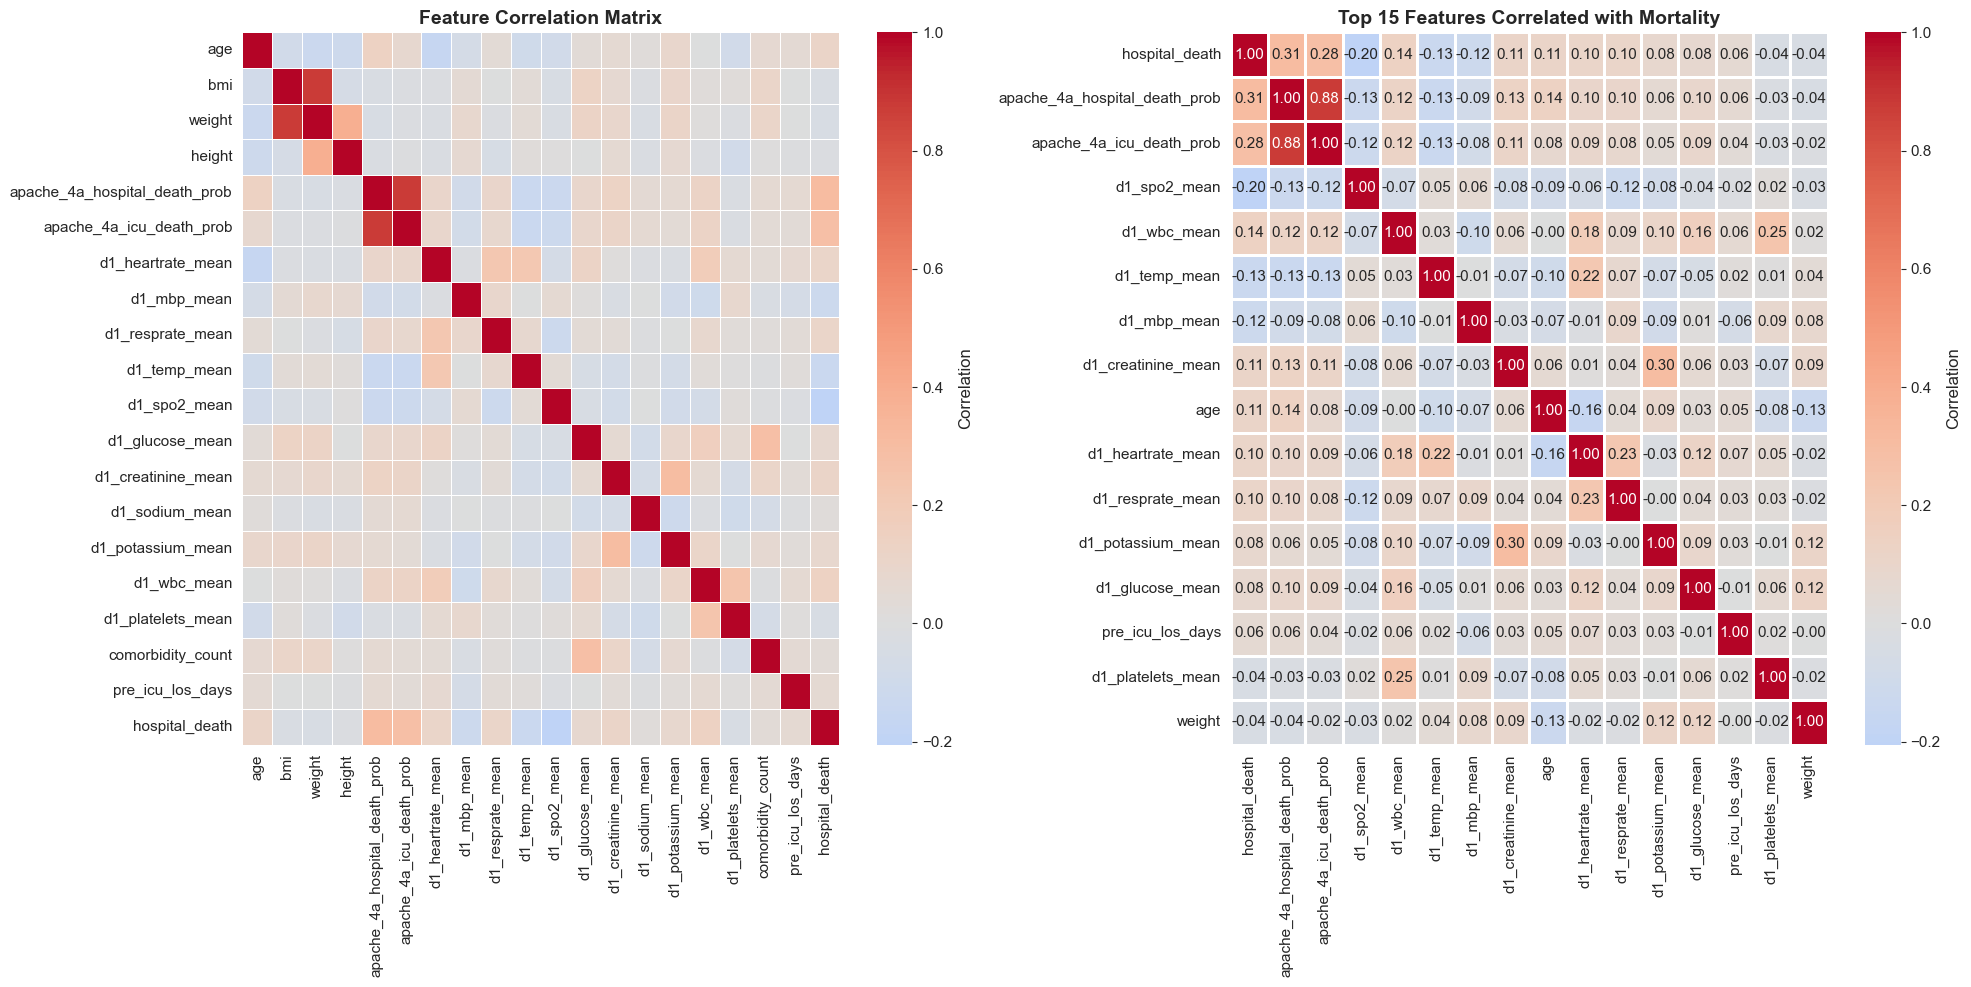


✅ Visualization saved: outputs/figures/10_correlation_heatmap.png
✅ Report saved: outputs/reports/mortality_correlations.csv


In [21]:
print("\n" + "="*80)
print("SECTION 6: FEATURE CORRELATION ANALYSIS")
print("="*80)

# Select key numeric features
key_features_corr = [
    'age', 'bmi', 'weight', 'height',
    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
    'd1_heartrate_mean', 'd1_mbp_mean', 'd1_resprate_mean', 'd1_temp_mean', 'd1_spo2_mean',
    'd1_glucose_mean', 'd1_creatinine_mean', 'd1_sodium_mean', 'd1_potassium_mean',
    'd1_wbc_mean', 'd1_hemoglobin_mean', 'd1_platelets_mean',
    'comorbidity_count', 'pre_icu_los_days',
    'hospital_death'
]

key_features_corr = [f for f in key_features_corr if f in df.columns]

corr_df = df[key_features_corr].corr()

mortality_corr = corr_df['hospital_death'].sort_values(ascending=False)
print(f"\n🔗 TOP 15 FEATURES CORRELATED WITH MORTALITY:\n")
print(mortality_corr.head(16).to_string())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Full correlation heatmap
sns.heatmap(corr_df, annot=False, cmap='coolwarm', center=0, 
            linewidths=0.5, cbar_kws={'label': 'Correlation'}, ax=axes[0])
axes[0].set_title('Feature Correlation Matrix', fontweight='bold', fontsize=14)

# Top features correlated with mortality
top_mortality_features = mortality_corr.abs().nlargest(16).index.tolist()
corr_subset = df[top_mortality_features].corr()

sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            linewidths=1, cbar_kws={'label': 'Correlation'}, ax=axes[1])
axes[1].set_title('Top 15 Features Correlated with Mortality', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig(r'C:\1Personal drive\job prep\me\D Analyst prep\Projects\ICU-Mortality-Prediction-WiDS2020\Outputs\Figures\10_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: outputs/figures/10_correlation_heatmap.png")
mortality_corr.to_csv(r'C:\1Personal drive\job prep\me\D Analyst prep\Projects\ICU-Mortality-Prediction-WiDS2020\Outputs\reports\mortality_correlations.csv')
print("✅ Report saved: outputs/reports/mortality_correlations.csv")


In [23]:

print("\n" + "="*80)
print("SECTION 7: STATISTICAL HYPOTHESIS TESTING")
print("="*80)

hypothesis_tests = []

# Test 1: Age difference
print(f"\n📊 TEST 1: Age Difference (T-test)")
age_survived = df[df['hospital_death'] == 0]['age'].dropna()
age_died = df[df['hospital_death'] == 1]['age'].dropna()
t_stat, p_val = stats.ttest_ind(age_survived, age_died)

print(f"   Mean age (Survived): {age_survived.mean():.1f} years")
print(f"   Mean age (Died): {age_died.mean():.1f} years")
print(f"   T-statistic: {t_stat:.4f}")
print(f"   P-value: {p_val:.2e}")
print(f"   Result: {'REJECT H0 - Significant difference' if p_val < 0.001 else 'FAIL TO REJECT H0'}")

hypothesis_tests.append({
    'Test': 'Age Difference',
    'Statistic': t_stat,
    'P_Value': p_val,
    'Result': 'Significant' if p_val < 0.001 else 'Not Significant'
})

# Test 2: Gender vs Mortality
if 'gender' in df.columns:
    print(f"\n📊 TEST 2: Gender vs Mortality (Chi-Square)")
    contingency = pd.crosstab(df['gender'], df['hospital_death'])
    chi2, p_val, dof, expected = chi2_contingency(contingency)
    
    print(f"   Chi-square: {chi2:.4f}")
    print(f"   P-value: {p_val:.2e}")
    print(f"   Result: {'REJECT H0' if p_val < 0.001 else 'FAIL TO REJECT H0'}")
    
    hypothesis_tests.append({
        'Test': 'Gender vs Mortality',
        'Statistic': chi2,
        'P_Value': p_val,
        'Result': 'Significant' if p_val < 0.001 else 'Not Significant'
    })

# Test 3: APACHE correlation
if 'apache_4a_hospital_death_prob' in df.columns:
    print(f"\n📊 TEST 3: APACHE Probability Correlation")
    apache_data = df[['apache_4a_hospital_death_prob', 'hospital_death']].dropna()
    r, p_val = pearsonr(apache_data['apache_4a_hospital_death_prob'], 
                        apache_data['hospital_death'])
    
    print(f"   Pearson r: {r:.4f}")
    print(f"   P-value: {p_val:.2e}")
    print(f"   Result: {'REJECT H0 - Significant correlation' if p_val < 0.001 else 'FAIL TO REJECT H0'}")
    
    hypothesis_tests.append({
        'Test': 'APACHE Correlation',
        'Statistic': r,
        'P_Value': p_val,
        'Result': 'Significant' if p_val < 0.001 else 'Not Significant'
    })

# Test 4: Comorbidity count
print(f"\n📊 TEST 4: Comorbidity Count Difference")
comorb_survived = df[df['hospital_death'] == 0]['comorbidity_count'].dropna()
comorb_died = df[df['hospital_death'] == 1]['comorbidity_count'].dropna()
t_stat, p_val = stats.ttest_ind(comorb_survived, comorb_died)

print(f"   Mean comorbidities (Survived): {comorb_survived.mean():.2f}")
print(f"   Mean comorbidities (Died): {comorb_died.mean():.2f}")
print(f"   T-statistic: {t_stat:.4f}")
print(f"   P-value: {p_val:.2e}")
print(f"   Result: {'REJECT H0' if p_val < 0.001 else 'FAIL TO REJECT H0'}")

hypothesis_tests.append({
    'Test': 'Comorbidity Count',
    'Statistic': t_stat,
    'P_Value': p_val,
    'Result': 'Significant' if p_val < 0.001 else 'Not Significant'
})

# Save results
hypothesis_df = pd.DataFrame(hypothesis_tests)
hypothesis_df.to_csv(r'C:\1Personal drive\job prep\me\D Analyst prep\Projects\ICU-Mortality-Prediction-WiDS2020\Outputs\reports\hypothesis_tests.csv', index=False)

print(f"\n\n📋 HYPOTHESIS TEST SUMMARY:\n")
print(hypothesis_df.to_string(index=False))
print("\n✅ Results saved: outputs/reports/hypothesis_tests.csv")



SECTION 7: STATISTICAL HYPOTHESIS TESTING

📊 TEST 1: Age Difference (T-test)
   Mean age (Survived): 61.7 years
   Mean age (Died): 68.5 years
   T-statistic: -33.0402
   P-value: 6.33e-238
   Result: REJECT H0 - Significant difference

📊 TEST 2: Gender vs Mortality (Chi-Square)
   Chi-square: 4.4739
   P-value: 3.44e-02
   Result: FAIL TO REJECT H0

📊 TEST 3: APACHE Probability Correlation
   Pearson r: 0.3110
   P-value: 0.00e+00
   Result: REJECT H0 - Significant correlation

📊 TEST 4: Comorbidity Count Difference
   Mean comorbidities (Survived): 0.30
   Mean comorbidities (Died): 0.38
   T-statistic: -11.3872
   P-value: 5.08e-30
   Result: REJECT H0


📋 HYPOTHESIS TEST SUMMARY:

               Test  Statistic  P_Value          Result
     Age Difference     -33.04     0.00     Significant
Gender vs Mortality       4.47     0.03 Not Significant
 APACHE Correlation       0.31     0.00     Significant
  Comorbidity Count     -11.39     0.00     Significant

✅ Results saved: outputs